2017 Edition

# Anomaly Detection in Network Traffic with K-means clustering

We can categorize machine learning algorithms into two main groups: **supervised learning** and **unsupervised learning**. With supervised learning algorithms, in order to predict unknown values for new data, we have to know the target value for many previously-seen examples. In contrast, unsupervised learning algorithms explore the data which has no target attribute to find some intrinsic structures in them.

Clustering is a technique for finding similar groups in data, called **clusters**. Clustering is often called an unsupervised learning task as no class values denoting an a priori grouping of the data instances are given.

In this notebook, we will use K-means, a very well-known clustering algorithm to detect anomaly network connections based on statistics about each of them. A thorough overview of K-means clustering, from a research perspective, can be found in the following wonderful [tutorial](http://theory.stanford.edu/~sergei/slides/kdd10-thclust.pdf).

## Goals
We expect students to:
* Learn (or revise) and understand the K-means algorithm
* Implement a simple K-means algorithm
* Use K-means to detect anomalies network connection data

## Steps

1. In section 1, we will have an overview about K-means then implement a simple version of it.
2. In section 2, we build models with and without categorical features.
3. Finally, in the last section, using our models, we will detect unusual connections.

# 1. K-means
## 1.1. Introduction
Clustering is a typical and well-known type of unsupervised learning. Clustering algorithms try to find natural groupings in data. Similar data points (according to some notion of similarity) are considered in the same group. We call these groups **clusters**.

K-Means clustering is a simple and widely-used clustering algorithm. Given value of $k$, it tries to build $k$ clusters from samples in the dataset. Therefore, $k$ is an hyperparameter of the model. The right value of $k$ is not easy to determine, as it highly depends on the data set and the way that data is featurized.

To measure the similarity between any two data points, K-means requires the definition of a distance function between data points. What is a distance? It is a value that indicates how close two data points are in their space. In particular, when data points lie in a $d$-dimensional space, the Euclidean distance is a good choice of a distance function, and is supported by MLLIB.

In K-means, a cluster is a group of points, with a representative entity called a centroid. A centroid is also a point in the data space: the center of all the points that make up the cluster. It's defined to be the arithmetic mean of the points. In general, when working with K-means, each data sample is represented in a $d$-dimensional numeric vector, for which it is easier to define an appropriate distance function. As a consequence, in some applications, the original data must be transformed into a different representation, to fit the requirements of K-means.

## 1.2. How does it work?
Given $k$, the K-means algorithm works as follows:

1. Randomly choose $k$ data points (seeds) to be the initial centroids
2. Assign each data point to the **closest centroid**
3. Re-compute (update) the centroids using the current cluster memberships
4. If a convergence criterion is not met, go to step 2

We can also terminate the algorithm when it reaches an iteration budget, which yields an approximate result.
From the pseudo-code of the algorithm, we can see that K-means clustering results can be sensitive to the order in which data samples in the data set are explored. A sensible practice would be to run the analysis several times, randomizing objects order; then, average the cluster centers of those runs and input the centers as initial ones for one final run of the analysis.

## 1.3. Illustrative example
One of the best ways to study an algorithm is trying implement it.
In this section, we will go step by step to implement a simple K-means algorithm.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

### Question 1

#### Question 1.1
<div class="alert alert-info">

Complete the below function to calculate an Euclidean distance between any two points in $d$-dimensional data space

</div>

In [1]:
import numpy as np

# calculate distance between two d-dimensional points
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum([np.power(p1[i] - p2[i], 2) for i in range(len(p1))]))

# test our function
assert (round(euclidean_distance([1,2,3] , [10,18,12]), 2) == 20.45), "Function's wrong"
%timeit euclidean_distance([1,2,3] , [10,18,12])

10000 loops, best of 3: 39.6 µs per loop


In [2]:
import numpy as np

# the previous function is extremely inefficient when compute distance between each point in 2 sets of points
# we revise this function so that p1(n*d) set of n points of d dimension and p2(m*d) set of m point of d dimension.
def euclidean_distance_mat(p1, p2):
    p1 = np.array(p1)
    p2 = np.array(p2)
    p12 = p1.dot(p1.transpose()).diagonal().reshape(-1, 1)
    p22 = p2.dot(p2.transpose()).diagonal().reshape(-1, 1)
    return np.sqrt(p12 - 2 * p1.dot(p2.transpose()) + p22.transpose())
#print(euclidean_distance_mat([1,2,3] , [10,18,12]))
# test our function
#assert (np.round(euclidean_distance_mat([1,2,3] , [10,18,12]), 2) == np.array([20.45])), "Function's wrong"
%timeit euclidean_distance_mat([[1,2,3], [1,2,3]] , [[10,18,12]])

The slowest run took 4.34 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 40.7 µs per loop


In [3]:
import numpy as np
import scipy.spatial.distance

# the previous function is extremely inefficient when compute distance between each point in 2 sets of points
# we revise this function so that p1(n*d) set of n points of d dimension and p2(m*d) set of m point of d dimension.
def euclidean_distance_mat_scipy(p1, p2):
    p1 = np.array(p1)
    p2 = np.array(p2)
    return scipy.spatial.distance.cdist(p1, p2, metric='euclidean')
#print(euclidean_distance_mat([1,2,3] , [10,18,12]))
# test our function
#assert (np.round(euclidean_distance_mat([1,2,3] , [10,18,12]), 2) == np.array([20.45])), "Function's wrong"
%timeit euclidean_distance_mat([[1,2,3], [1,2,3]] , [[10,18,12]])

10000 loops, best of 3: 40.2 µs per loop


<div class="alert alert-warning">
The function to calculate the distance for each pair of points is inefficient when used to compute the distance between each pair of points in 2 sets of points. We implement the generic pair of point distance for 2 sets of points. With 2 large sets of point this algorithm is much faster than calculating the distance for each pair of point by iterating through each element.
</div>

#### Question 1.2
<div class="alert alert-info">

Given a data point and the current set of centroids, complete the function below to find the index of the closest centroid for that data point.

</div>

In [4]:
def find_closest_centroid(datapoint, centroids):
    # find the index of the closest centroid of the given data point.
    distances = list(map(lambda centroid: euclidean_distance(datapoint, centroid), centroids))
    return np.argmin(distances)

assert(find_closest_centroid( [1,1,1], [ [2,1,2], [1,2,1], [3,1,2] ] ) == 1), "Function's wrong"
%timeit find_closest_centroid( [1,1,1], [ [2,1,2], [1,2,1], [3,1,2] ])

10000 loops, best of 3: 155 µs per loop


In [5]:
def find_closest_centroid_mat(datapoints, centroids):
    # find the index of the closest centroid of the given data point.
    distances = euclidean_distance_mat(datapoints, centroids)
    return np.argmin(distances, axis=1)

assert(find_closest_centroid( [1,1,1], [ [2,1,2], [1,2,1], [3,1,2] ] ) == 1), "Function's wrong"
%timeit find_closest_centroid_mat( [[2,1,2], [1,2,1]], [[2,1,2], [1,2,1], [3,1,2]] )

10000 loops, best of 3: 44 µs per loop


<div class="alert alert-warning">
We modify this function to find the closest centroid for each data point in a dataset. The time of matrix multiplication is much faster than map function
</div>

#### Question 1.3
<div class="alert alert-info">

Write a function to randomize `k` initial centroids.

</div>

In [6]:
np.random.seed(22324)

# randomize initial centroids
def randomize_centroids(data, k):
    centroids = list(range(len(data)))
    np.random.shuffle(centroids)
    return [data[centroid] for centroid in centroids[:k]]

assert(len(
    randomize_centroids(
        np.array([ 
            np.array([2,1,2]), 
            np.array([1,2,1]), 
            np.array([3,1,2]) 
             ]), 
        2)) == 2), "Wrong function"

#### Question 1.4
<div class="alert alert-info">

Write function `check_converge` to check the stop criteria of the algorithm.

</div>

In [7]:
MAX_ITERATIONS = 1000

# return True if clusters have converged , otherwise, return False  
def check_converge(centroids, old_centroids, num_iterations, threshold=0):
    # if it reaches an iteration budget
    if(num_iterations < MAX_ITERATIONS):
        return True
    # check if the centroids don't move (or very slightly)
    return (len(list(filter(lambda x: euclidean_distance(x[0], x[1])>threshold ,zip(centroids, old_centroids)))) == 0)

In [8]:
MAX_ITERATIONS = 1000

# return True if clusters have converged , otherwise, return False  
def check_converge_mat(centroids, old_centroids, num_iterations, threshold=0):
    # if it reaches an iteration budget
    if(num_iterations < MAX_ITERATIONS):
        return True
    # check if the centroids don't move (or very slightly)
    return (len(list(filter(lambda x: euclidean_distance([x[0]], [x[1]])>threshold ,zip(centroids, old_centroids)))) == 0)

#### Question 1.5
<div class="alert alert-info">

Write function `update_centroid` to update the new positions for the current centroids based on the position of their members.

</div>

In [9]:
# centroids: a list of centers
# cluster: a list of k elements. Each element i-th is a list of data points that are assigned to center i-th
def update_centroids(centroids, cluster):
    new_centroids = []
    for i in range(len(centroids)):
        new_centroids.append(list(np.average(cluster[i],axis=0)))
    return new_centroids


#### Question 1.6
<div class="alert alert-info">

Complete the K-means algorithm skeleton below, with the functions you wrote above.

</div>

In [10]:
# data : set of data points
# k : number of clusters
# centroids: initial list of centroids
def kmeans(data, k=2, centroids=None):
    
    # randomize the centroids if they are not given
    if not centroids:
        centroids = randomize_centroids(data, k)

    old_centroids = centroids[:]

    iterations = 0
    while True:
        iterations += 1

        # init empty clusters
        clusters = [[] for i in range(k)]

        # assign each data point to the closest centroid
        for datapoint in data:
            # find the closest center of each data point
            centroid_idx = find_closest_centroid(datapoint, centroids)
            
            # assign datapoint to the closest cluster
            clusters[centroid_idx].append(datapoint)
        
        # keep the current position of centroids before changing them
        old_centroids = centroids[:]
        
        # update centroids
        centroids = update_centroids(centroids, clusters)
        
        # if the stop criteria are met, stop the algorithm
        if check_converge(centroids, old_centroids, iterations, threshold=0):
            break
    
    return centroids

In [11]:
# data : set of data points
# k : number of clusters
# centroids: initial list of centroids
def kmeans_mat(data, k=2, centroids=None):
    
    # randomize the centroids if they are not given
    if not centroids:
        centroids = randomize_centroids(data, k)

    old_centroids = centroids[:]

    iterations = 0
    while True:
        iterations += 1

        # init empty clusters
        clusters = [[] for i in range(k)]

        # assign each data point to the closest centroid
        
        # find the closest center of each data point
        centroid_idx_mat = find_closest_centroid_mat(data, centroids)
        # assign datapoint to the closest cluster
        for idx in np.arange(len(data)):
            clusters[centroid_idx_mat[idx]].append(data[idx])
        # keep the current position of centroids before changing them
        old_centroids = centroids[:]
        # print(centroids, clusters)
        # update centroids
        centroids = update_centroids(centroids, clusters)
        
        # if the stop criteria are met, stop the algorithm
        if check_converge(centroids, old_centroids, iterations, threshold=0):
            break
    
    return centroids

<div class="alert alert-warning">
We modify the kmean function to use our euclidean distance modification.
</div>

Next, we will test our algorithm on [Fisher's Iris dataset](http://en.wikipedia.org/wiki/Iris_flower_data_set), and plot the resulting clusters in 3D.

#### Question 1.7
<div class="alert alert-info">

The code below can be used to test your algorithm with three different datasets: `Iris`, `Moon` and `Blob`.
Run your algorithm to cluster datapoints in these datasets, plot the results and discuss about them. Do you think that our algorithm works well? Why?

</div>

/opt/conda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:
/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


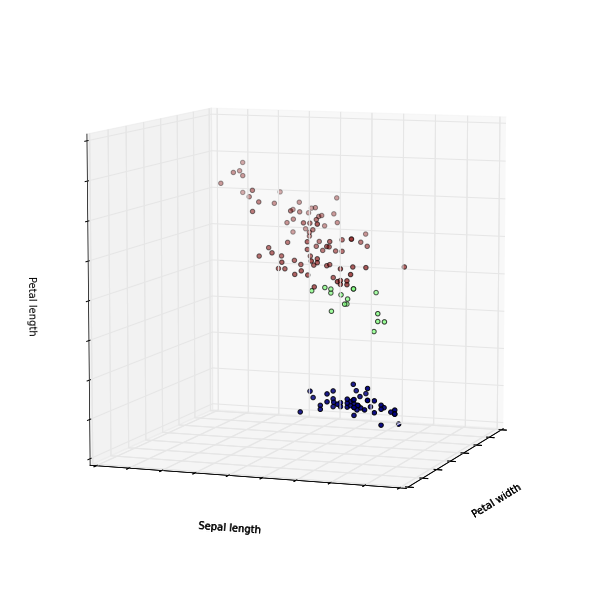

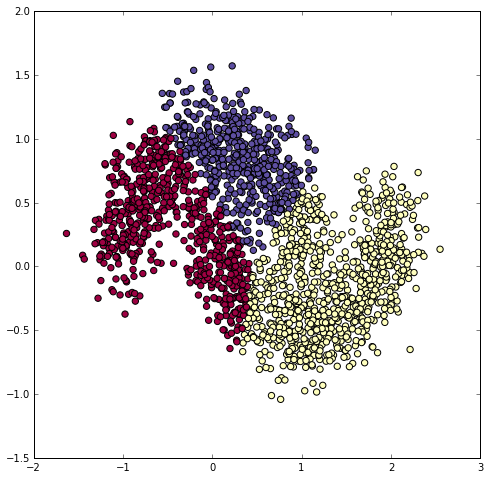

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in sqrt


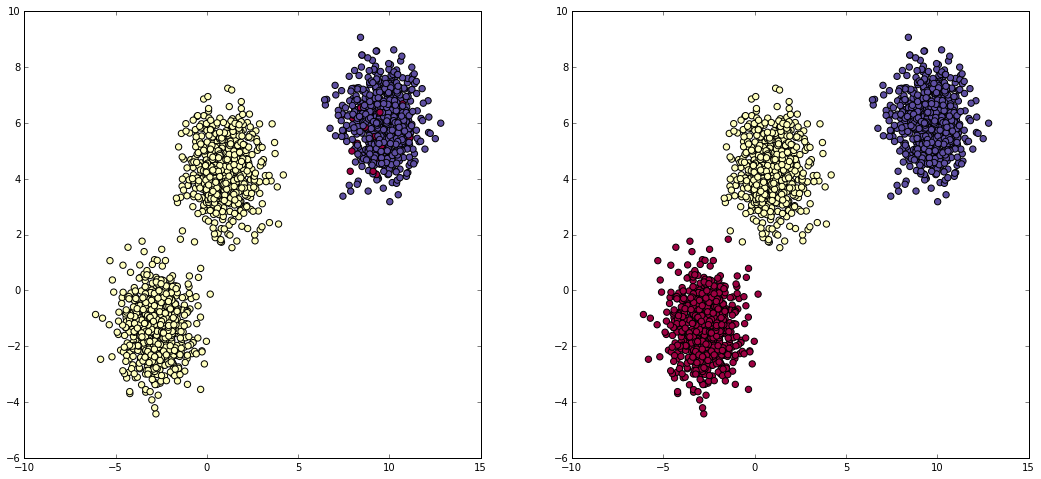

In [12]:
%matplotlib inline

from sklearn import datasets, cluster
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# load data
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target
# do the clustering
# centers = kmeans(X_iris, k=3)
# labels = [find_closest_centroid(p, centers) for p in X_iris]
centers = kmeans_mat(X_iris, k=3)
labels = find_closest_centroid_mat(X_iris, centers)


#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
ax.scatter(X_iris[:, 3], X_iris[:, 0], X_iris[:, 2], c=labels)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')
plt.show()

# moon
plt.figure(figsize=(8,8))
X, y = datasets.make_moons(2000, noise=0.2)
centers = kmeans_mat(X, k=3)
# labels = [find_closest_centroid(p, centers) for p in X]
labels = find_closest_centroid_mat(X, centers)
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)
plt.show()

# blob
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
np.random.seed(0)
X, y = datasets.make_blobs(n_samples=2000, centers=3, n_features=20, random_state=0)
centers = kmeans_mat(X, k=3)
labels = find_closest_centroid_mat(X, centers)
fig = plt.figure(1, figsize=(8, 8))
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)


plt.subplot(1,2,2)
np.random.seed(3)
X, y = datasets.make_blobs(n_samples=2000, centers=3, n_features=20, random_state=0)

centers = kmeans_mat(X, k=3)
labels = find_closest_centroid_mat(X, centers)

fig = plt.figure(1, figsize=(8, 8))
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)

plt.show()

<div class="alert alert-warning">
We can see that in the first plot the clustering works quite well indeed it is divided in three groups where the elements inside are actually close to each other. This is not true always because in certain iterations some elementes that should belong to the blue group are instead associated to the green one. This is due to the randomisation of the centroids and the outcome of our algorithm it's strongly related to the set of initial centroids and data itself.
<br><br>
In the second one the elements are really close to each other but still the algorithm is able to evaluate 3 well separated groups
<br><br>
For the last dataset the outcome it's strongly correleted to the initial centroids. Here, if we try to plot data we can see 3 different groups but if we try to cluster this set, the outcome most of iterations is really bad. As you can see in the leften plot of the last two.

</div>

That's enough about K-means for now. In the next section, we will apply MMLIB's K-means on Spark to deal with a large data in the real usecase.


# 2. Usecase: Network Intrusion 

Some attacks attempt to flood a computer with network traffic. In some other cases, attacks attempt to exploit flaws in networking software in order to gain unauthorized access to a computer. Detecting an exploit in an incredibly large haystack of network requests is not easy.

Some exploit behaviors follow known patterns such as scanning every port in a short of time, sending a burst of request to a port... However, the biggest threat may be the one that has never been detected and classified yet. Part of detecting potential network intrusions is detecting anomalies. These are connections that aren't known to be attacks, but, do not resemble connections that have been observed in the past.

In this notebook, K-means is used to detect anomalous network connections based on statistics about each of them.


## 2.1. Data
The data comes from [KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). The dataset is about 708MB and contains about 4.9M connections. For each connection, the data set contains information like the number of bytes sent, login attempts, TCP errors, and so on. Each connection is one line of CSV-formatted data, containing 38 features: back, buffer_overflow, ftp_write, guess_passwd, imap, ipsweep, land, loadmodule, multihop, neptune, nmap, normal, perl, phf, pod, portsweep, rootkit, satan, smurf, spy, teardrop, warezclient, warezmaster. For more details about each feature, please follow this [link](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html).

Many features take on the value 0 or 1, indicating the presence or absence of a behavior such as `su_attempted` in the 15th column. Some features are counts, like `num_file_creations` in the 17th columns. Some others are the number of sent and received bytes.

## 2.2. Clustering without using categorical features

First, we need to import some packages that are used in this notebook.

In [13]:
import os
import sys
import re
import time
from pyspark import SparkContext
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
from pyspark.mllib.clustering import KMeans, KMeansModel

input_path = "/datasets/k-means/kddcup.data"
raw_data = sc.textFile(input_path, 12)

### 2.2.1. Loading data

There are two types of features: numerical features and categorical features.
Currently, to get familiar with the data and the problem, we only use numerical features. In our data, we also have pre-defined groups for each connection, which we can use later as our "ground truth" for verifying our results.

**Note 1**: we don't use the labels in the training phase!!!

**Note 2**: in general, since clustering is un-supervised, you don't have access to ground truth. For this reason, several metrics to judge the quality of clustering have been devised. For a short overview of such metrics, follow this [link](https://en.wikipedia.org/wiki/Cluster_analysis#Internal_evaluation). Note that computing such metrics, that is trying to assess the quality of your clustering results, is as computationally intensive as computing the clustering itself!

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 2
<div class="alert alert-info">

Write function `parseLine` to construct a tuple of `(label, vector)` for each connection, extract the data that contains only the data points (without label), then print the number of connections.

</div>

Where,

* `label` is the pre-defined label of each connection
* `vector` is a numpy array that contains values of all features, but the label and the categorial features at index `1,2,3` of each connection. Each `vector` is a data point.

In [14]:
def parseLine(line):
    cols = line.split(',')
    # label is the last column
    label = cols[-1]
    
    # vector is every column, except the label
    vector = cols[:-1]
    
    # delete values of columns that have index 1->3 (categorical features)
    vector = [vector[0]]+vector[4:]
    
    # convert each value from string to float
    vector = np.array(vector).astype(float)
    
    return (label, vector)

labelsAndData = raw_data.map(parseLine)

# we only need the data, not the label
data = labelsAndData.map(lambda x: x[1]).cache()


# number of connections
n = data.count()

In [15]:
data.take(2)

[array([  0.00000000e+00,   2.15000000e+02,   4.50760000e+04,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]),
 array([  0.00000000e+00,   1.62000000e+02,   4.52800000e+03,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 3
<div class="alert alert-info">

Using K-means algorithm of MLLIB, cluster the connections into two groups then plot the result. Why two groups? In this case, we are just warming up, we're testing things around, so "two groups" has no particular meaning.

</div>  

You can use the following parameters:  

<ul>

  <li>`maxIterations=10`</li>
  <li>`runs=10`</li>
  <li>`initializationMode="random"`</li>

</ul>  

Discuss the result from your figure.

In [16]:
start_time = time.time()
clusters = KMeans.train(data, 2, maxIterations=10,
        runs=10, initializationMode="random")
print("Run time: ", time.time() - start_time)

/opt/spark/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


Run time:  10.606321573257446


In [17]:
import random
# do the clustering
centers = clusters.centers
SAMPLE_SIZE = 0.3
RANDOM_SEED = 42

data2 = np.array(data.sample(False, SAMPLE_SIZE, random.seed(RANDOM_SEED)).collect())
labels = data.map(lambda p: clusters.predict(p)).sample(False, SAMPLE_SIZE,random.seed(RANDOM_SEED)).collect()

num = len(data2[:, 10])

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


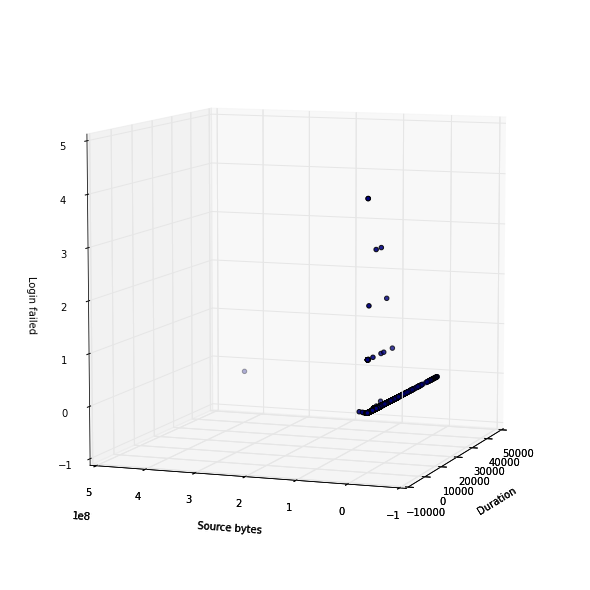

In [18]:
#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
ax.scatter(data2[:, 0], data2[:, 1], data2[:, 7], c=labels)

ax.set_xlabel('Duration')
ax.set_ylabel('Source bytes')
ax.set_zlabel('Login failed')

plt.show()

Percentage of login with root privileges:  0.006467411394761942
Percentage of hot login:  6.807801468170464e-05
Percentage of guest login:  0.08577829849894786
Percentage of connection width outgoing byte greater than 0:  76.49313807651016


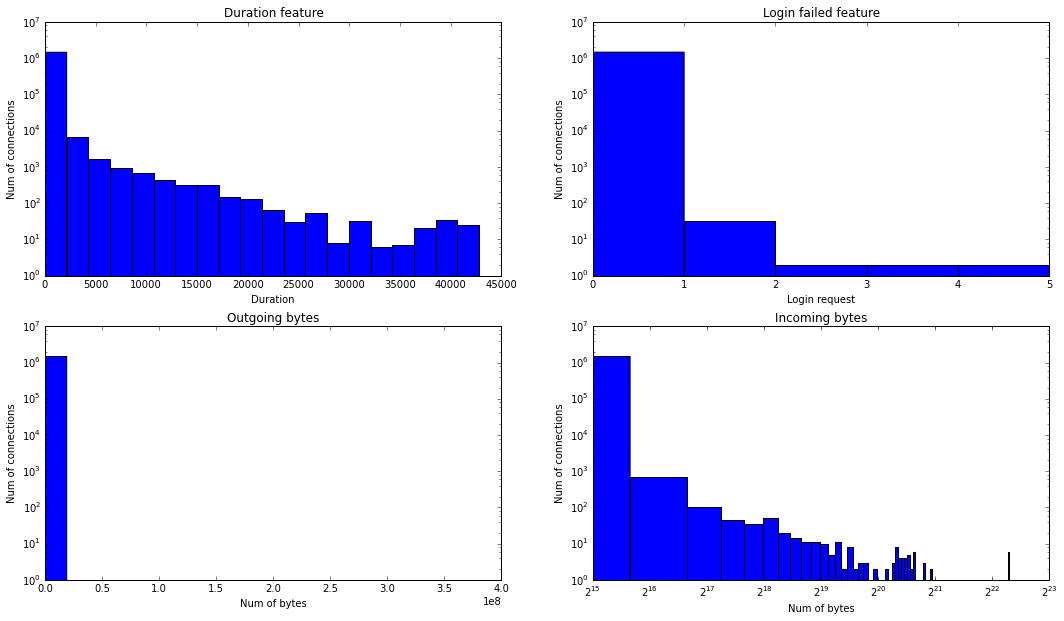

In [19]:
plt.figure(figsize=(18,10))

plt.subplot(2, 2, 1)
plt.hist(data2[:, 0], 20)
plt.yscale('log', nonposy='clip')
plt.title("Duration feature")
plt.xlabel("Duration")
plt.ylabel("Num of connections")

plt.subplot(2, 2, 2)
plt.hist(data2[:, 7], range(6))
plt.yscale('log', nonposy='clip')
plt.title("Login failed feature")
plt.xlabel("Login request")
plt.ylabel("Num of connections")

plt.subplot(2, 2, 3)
plt.hist(data2[:, 1], 20)
plt.yscale('log', nonposy='clip')
plt.title("Outgoing bytes")
plt.xlabel("Num of bytes")
plt.ylabel("Num of connections")

fig = plt.subplot(2, 2, 4)
plt.hist(data2[:, 2], 100)
plt.yscale('log', nonposy='clip')
fig.set_xscale('log', basex=2)
plt.title("Incoming bytes")
plt.xlabel("Num of bytes")
plt.ylabel("Num of connections")

num_root = len(list(filter(lambda x: x==1, data2[:, 10])))
print("Percentage of login with root privileges: ", num_root/num*100)
num_hot = len(list(filter(lambda x: x==1, data2[:, 17])))
print("Percentage of hot login: ", num_hot/num*100)
num_guest = len(list(filter(lambda x: x==1, data2[:, 18])))
print("Percentage of guest login: ", num_guest/num*100)
num_out_data = len(list(filter(lambda x: x>0, data2[:, 1])))
print("Percentage of connection width outgoing byte greater than 0: ", num_out_data/num*100)

plt.show()

<div class="alert alert-warning">
Here we wanted to understand data distribution of some features that we considered relevant for our problem.
<br><br>
We didn't plot the firsts features because even if we think that they are very useful for the intrusion detection they are boolean feature:
<br>
- login with root privileges: the value is really low as expected, most of connection should be indeed with user privileges; <br>
- hot login: user in the hot list;<br>
- guest login: logins of not registered user, so possible attackers; <br>

Then we plotted the duration of the connections and most of them lasts less then one hour but we can see that a non negligible number of connections last 11 hours. <br>
Form login failure plot we could say that there was no attempt of brute force attack on some user password because the maximum value of failure is 5.<br>
For the incoming bytes most of connection are in the order of hundreds of kB instead the outgoing connection are in the order of MB.
<br>
<br>
After this preliminary analysis we know how the data are distribuited and we can use these informtion to notice future anomalies.
</div>

### 2.2.3. Evaluating model

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 4
<div class="alert alert-info">

One of the simplest method to evaluate our result is calculate the Within Set Sum of Squared Errors (WSSSE), or simply, 'Sum of Squared Errors'. An error of a data point is defined as it's distance to the closest cluster center.

</div>


In [20]:
from operator import add

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(clusters, point):
    closest_center = clusters.centers[clusters.predict(point)]
    return np.power(euclidean_distance(closest_center, point), 2)

In [21]:
start_time = time.time()
WSSSE = data.map(lambda x: error(clusters, x)).reduce(add)
print("Elapsed time: ", time.time() - start_time)

print("Within Set Sum of Squared Error = " + str(WSSSE))

Elapsed time:  119.83535957336426
Within Set Sum of Squared Error = 3.05254895755e+18


In [22]:
from operator import add

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error_mat(clusters, point):
    closest_center = clusters.centers[clusters.predict(point)]
    return np.square(euclidean_distance_mat([closest_center], [point]))

In [23]:
start_time = time.time()
WSSSE = data.map(lambda x: error_mat(clusters, x)).reduce(add)
print("Elapsed time: ", time.time() - start_time)

print("Within Set Sum of Squared Error = " + str(WSSSE))

Elapsed time:  36.933385610580444
Within Set Sum of Squared Error = [[  3.05254896e+18]]



<div class="alert alert-warning">
Use matrix operation during calculation greatly speed up code, our euclidean calculation method significantly outperform the list version.
</div>


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)


#### Question 5

<div class="alert alert-info">

This is a good opportunity to use the given labels to get an intuitive sense of what went into these two clusters, by counting the labels within each cluster. Complete the following code that uses the model to assign each data point to a cluster, and counts occurrences of cluster and label pairs.  

What do you think about the result?

</div>

In [24]:
start_time = time.time()
clusterLabelCount = data.map(lambda p: (clusters.predict(p), 1)).countByKey()
print("Run time: ", time.time() - start_time)

print("Our clusters:")
for item in clusterLabelCount:
    print(item, clusterLabelCount[item])

Run time:  19.344799518585205
Our clusters:
0 5
1 4898426


In [25]:
start_time = time.time()
clusterLabelCount = labelsAndData.map(lambda x: (x[0], 1)).countByKey()
print("Run time: ", time.time() - start_time)

# print(clusterLabelCount)
# print("Original clusters:")
# for item in clusterLabelCount:
#     print(item, clusterLabelCount[item])

Run time:  20.703572034835815


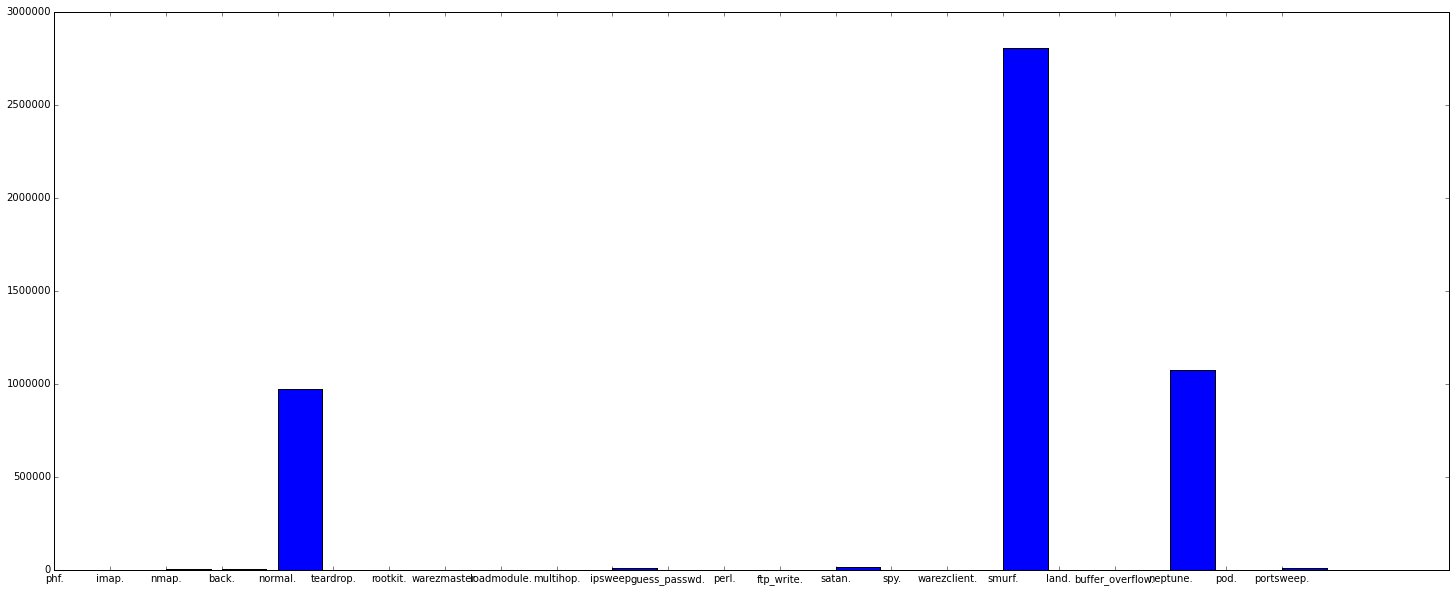

In [26]:
plt.figure(figsize=(25,10))
plt.bar(np.arange(len(clusterLabelCount)), [clusterLabelCount[i] for i in clusterLabelCount] )
plt.xticks(np.arange(len(clusterLabelCount)), [i for i in clusterLabelCount] );

<div class="alert alert-warning">

Here the result is really bad because all elements are concentrated in one group. We could not expect a good result trying to cluster the datasets in 2 groups because we have a lot of connections and features and 2 groups are not enough to describe them. But still the outcome it's particularly bad, probably those 5 value are outliers and so the algorithm converges to this result.<br>
We did the same using the given labels, here most of connections are concentrated in few groups that are the non-malicious connection.
<br>

</div>

### 2.2.4. Choosing K

How many clusters are appropriate for a dataset? In particular, for our own dataset, it's clear that there are 23 distinct behavior patterns in the data, so it seems that k could be at least 23, or likely, even more. In other cases, we even don't have any information about the number of patterns at all (remember, generally your data is not labelled!). Our task now is finding a good value of $k$. For doing that, we have to build and evaluate models with different values of $k$. A clustering could be considered good if each data point were near to its closest centroid. One of the ways to evaluate a model is calculating the Mean of Squared Errors of all data points.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 6
<div class="alert alert-info">
Complete the function below to calculate the MSE of each model that is corresponding to each value of $k$.  


Plot the results. From the obtained result, what is the best value for $k$? Why?

</div>

In [27]:
# k: the number of clusters
def clusteringScore(data, k):
    clusters = KMeans.train(data, k, maxIterations=10,
        runs=10, initializationMode="random")
    # calculate mean square error
    return data.map(lambda x: error_mat(clusters, x)).reduce(add)/n

In [28]:
from multiprocessing import Pool

In [29]:
scores = []
k_range = [60,70,80,90,100,110]
start_time = time.time()

def runcluster(k):
    score = clusteringScore(data, k)
    scores.append(score)
    print("With k=", k, "the score is:", score)
    return score

# with Pool(len(k_range)) as p:
#     p.map(runcluster, k_range)
for k in k_range:
    runcluster(k)
print("Elapsed time: ", time.time() - start_time)

/opt/spark/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


With k= 60 the score is: [[  2.02970679e+11]]
With k= 70 the score is: [[  1.97211761e+11]]
With k= 80 the score is: [[  1.97203408e+11]]
With k= 90 the score is: [[  2.02393926e+11]]
With k= 100 the score is: [[  2.02395353e+11]]
With k= 110 the score is: [[  2.02202631e+11]]
Elapsed time:  1554.8884181976318


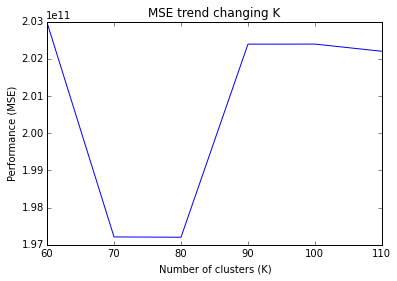

In [30]:
# plot results
scores = np.array(scores).reshape(-1,1)
plt.plot(k_range, scores)
plt.title("MSE trend changing K")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Performance (MSE)")
plt.show()

<div class="alert alert-warning">

As expected the error decreses as we increse the number of cluster but after a certain value the slope would decrese.
<br>
In the case of K=80 che curve is slightly higher copared with k=70 that's because the algorithm in that iteration converged in an unfortunate situation probably due to the initial centroids.
<br>
Using the new error_mat function, our performance is improved significantly. Pair-wise distance are best computed with matrix.
</div>

### 2.2.5 Normalizing features

K-means clustering treats equally all dimensions/directions of the space and therefore tends to produce more or less spherical (rather than elongated) clusters. In this situation, leaving variances uneven is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance.

In our notebook, since Euclidean distance is used, the clusters will be influenced strongly by the magnitudes of the variables, especially by outliers. Normalizing will remove this bias. 

Each feature can be normalized by converting it to a standard score. This means subtracting the mean of the feature’s values from each value, and dividing by the standard deviation

$normalize_i=\frac{feature_i - \mu_i}{\sigma_i}$

Where,

* $normalize_i$ is the normalized value of feature $i$
* $\mu_i$ is the mean of feature $i$
* $\sigma_i$ is the standard deviation of feature $i$


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 7
<div class="alert alert-info">

Complete the code below to normalize the data. Print the first 5 lines of the new data.

</div>

<div class="label label-success">HINT</div> If $\sigma_i = 0$ then $normalize_i=feature_i - \mu_i$

In [31]:
from operator import add

def normalizeData(data):
    # number of connections
    n = data.count()

    # calculate the sum of each feature
#     sums = data.flatMap(lambda x: [(i, x[i]) for i in range(len(x))]).reduceByKey(add).sortByKey()
    sums = data.flatMap(lambda x: zip(np.arange(len(x)), x)).reduceByKey(add).sortByKey()
    #print(sums.collect())

    # calculate means
    means = np.array(sums.map(lambda x: x[1]/n).collect())

    # calculate the sum square of each feature
#     sumSquares = data.flatMap(lambda x: [(i, np.power(x[i]-means[i], 2)) for i in range(len(x))])\
#                 .reduceByKey(np.add)\
#                 .sortByKey()
    sumSquares = data.flatMap(lambda x: zip(np.arange(len(x)) , np.square(np.array(x) - means) ))\
                .reduceByKey(np.add)\
                .sortByKey()
    #print(sumSquares)

    # calculate standard deviation of each feature # chua sqrt moi them :|
    stdevs = np.sqrt(np.array(sumSquares.map(lambda x: 1 if (x[1]==0) else x[1]/n).collect()))
    #print(stdevs)

    def normalize(point):
        point = np.array(point)
        return ((point-means)/stdevs)

    return data.map(normalize)

start_time = time.time()
normalizedData = normalizeData(data).cache()
print(normalizedData.take(5))
print("Elapsed time: ", time.time() - start_time)

[array([ -6.68331854e-02,  -1.72038228e-03,   6.81884351e-02,
        -2.39084686e-03,  -1.51391734e-02,  -1.10348462e-03,
        -2.65207600e-02,  -4.39091558e-03,   2.44279187e+00,
        -2.09732783e-03,  -8.25770840e-03,  -4.54646139e-03,
        -3.28458917e-03,  -9.57233922e-03,  -8.50457842e-03,
        -2.87561127e-02,   0.00000000e+00,  -6.38979005e-04,
        -2.89113034e-02,  -1.57541507e+00,  -1.19624324e+00,
        -4.66042614e-01,  -4.65755574e-01,  -2.48285775e-01,
        -2.48130352e-01,   5.39733093e-01,  -2.56056520e-01,
        -2.01059296e-01,  -3.63913926e+00,  -1.78651044e+00,
        -1.83302273e+00,  -2.82939000e-01,  -1.25793664e+00,
        -1.56668488e-01,  -4.66404784e-01,  -4.65453641e-01,
        -2.50831829e-01,  -2.49631966e-01]), array([ -6.68331854e-02,  -1.77667956e-03,   5.32451452e-03,
        -2.39084686e-03,  -1.51391734e-02,  -1.10348462e-03,
        -2.65207600e-02,  -4.39091558e-03,   2.44279187e+00,
        -2.09732783e-03,  -8.25770840e-

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 8
<div class="alert alert-info">

Using the new data, build different models with different values of $k \in [60,70,80,90,100,110]$. Evaluate the results by plotting them and choose the best value of $k$.

</div>

In [32]:
scores_norm = []
k_range_norm = [60,70,80,90,100,110]
for k in k_range_norm:
    score_norm = clusteringScore(normalizedData, k)
    scores_norm.append(score_norm)
    print("With k=", k, "the score is:", score_norm)

/opt/spark/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


With k= 60 the score is: [[ 14.882518]]
With k= 70 the score is: [[ 12.54400071]]
With k= 80 the score is: [[ 13.22881191]]
With k= 90 the score is: [[ 13.6127764]]
With k= 100 the score is: [[ 12.0829256]]
With k= 110 the score is: [[ 12.2922978]]


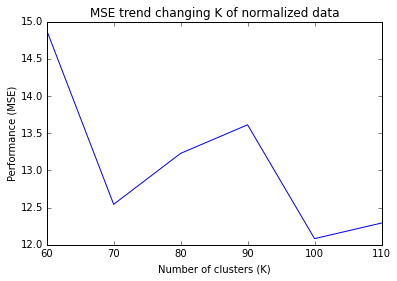

In [33]:
# Plot resutls
scores_norm = np.array(scores_norm).reshape(-1,1)
plt.plot(k_range_norm,scores_norm)
plt.title("MSE trend changing K of normalized data")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Performance (MSE)")

<div class='alert alert-warning'>

As in the previous case the trend of the curve it's the same but we can see that the range of values it's completly different due to the normalization of the data. With normalization, the score is significantly lower. 
<br>
The normalization method is used bring all feature to the same value range so that they are treated with the same importance. 


</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 9
<div class="alert alert-info">

Plot the clustering result to see the difference between before and after normalizing features. Discuss about the difference and explain why and if normalization was useful.

</div>

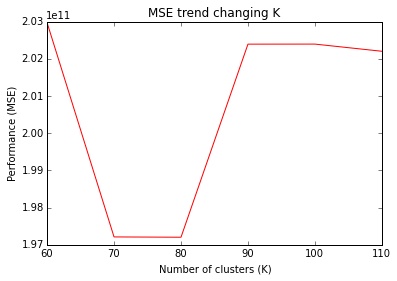

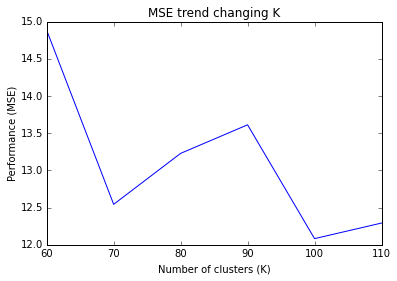

In [34]:
# plot results
# k_range_norm, scores_norm, 'b'
plt.plot(k_range, scores, 'r')
plt.title("MSE trend changing K")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Performance (MSE)")
plt.show()
plt.plot(k_range_norm, scores_norm, 'b')
plt.title("MSE trend changing K")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Performance (MSE)")
plt.show()

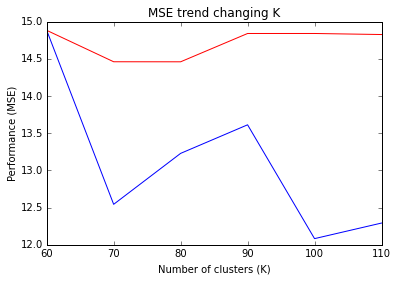

In [35]:
factor = scores[0]/scores_norm[0]
scores_fac = [x/factor for x in scores]

# plot results
plt.plot(k_range, scores_fac, 'r', k_range_norm, scores_norm, 'b')
plt.title("MSE trend changing K")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Performance (MSE)")

plt.show()

<div class="alert alert-warning">


We plot the scores as they are we cannot see anything because the values are too far due to the normalization.
So we multiplied all of them to a factor which is the division between the firsts two, but this is not enought to compare the two plots because the standard deviation of those scores is much different so we should apply a more complicated function in order to have a more rappresentative comparison.


</div>

## 2.3. Clustering using categorical features

### 2.3.1 Loading data

In the previous section, we ignored the categorical features of our data: this is not a good idea, since these categorical features can be important in providing useful information for clustering.
The problem is that K-means (or at least, the one we have developed and the one we use from MLLib) only work with data points in a metric space. Informally, this means that operations such as addition, subtraction and computing the mean of data points are trivial and well defined. For a more formal definition of what a metric space is, follow this [link](https://en.wikipedia.org/wiki/Metric_space#Definition).

What we will do next is to transform each categorical feature into one or more numerical features. This approach is very widespread: imagine for example you wanted to use K-means to cluster text data. Then, the idea is to transform text data in $d$-dimensional vectors, and a nice way to do it is to use [word2vec](http://deeplearning4j.org/word2vec). If you're interested, follow this link to a nice [blog post](http://bigdatasciencebootcamp.com/posts/Part_3/clustering_news.html) on the problem.

There are two approaches:

* **Approach 1**: mapping **one** categorical feature to **one** numerical feature. The values in each categorical feature are encoded into unique numbers of the new numerical feature. For example, ['VERY HOT','HOT', 'COOL', 'COLD', 'VERY COLD'] will be encoded into [0,1,2,3,4,5]. However, by using this method, we implicit assume that the value of 'VERY HOT' is smaller than 'HOT'... This is not generally true.

* **Approach 2**: mapping **one** categorical feature to **multiple** numerical features. Basically, a single variable with $n$ observations and $d$ distinct values, to $d$ binary variables with $n$ observations each. Each observation indicating the presence (1) or absence (0) of the $d^{th}$ binary variable. For example, ['house', 'car', 'tooth', 'car'] becomes 
```
[
[1,0,0,0],
[0,1,0,0],
[0,0,1,0],
[0,0,0,1],
]
```

We call the second approach "one-hot encoding". By using this approach, we keep the same role for all values of categorical features.



![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 10

<div class="alert alert-info">

Calculate the number of distinct categorical features value (at index `1,2,3`). Then construct a new input data using one-hot encoding for these categorical features (don't throw away numerical features!).

</div>

In [36]:
# Different values of each feature
def get_categorical_features(line):
    cols = line.split(',')
    return cols[1:4]
dictionary = raw_data.flatMap(get_categorical_features).distinct().collect()
bDictionary = sc.broadcast(dictionary)
print(bDictionary.value)

['whois', 'pop_3', 'harvest', 'SH', 'uucp_path', 'other', 'systat', 'ecr_i', 'vmnet', 'remote_job', 'http', 'S1', 'kshell', 'OTH', 'time', 'name', 'Z39_50', 'tftp_u', 'udp', 'netbios_dgm', 'ftp', 'ldap', 'discard', 'domain_u', 'REJ', 'S2', 'eco_i', 'finger', 'http_2784', 'private', 'printer', 'sql_net', 'tcp', 'sunrpc', 'nnsp', 'daytime', 'exec', 'RSTOS0', 'pop_2', 'iso_tsap', 'urp_i', 'IRC', 'urh_i', 'http_443', 'RSTO', 'netbios_ns', 'ftp_data', 'domain', 'ctf', 'bgp', 'hostnames', 'mtp', 'netstat', 'login', 'klogin', 'ssh', 'nntp', 'S0', 'imap4', 'aol', 'tim_i', 'efs', 'RSTR', 'shell', 'csnet_ns', 'rje', 'smtp', 'S3', 'X11', 'telnet', 'http_8001', 'supdup', 'red_i', 'icmp', 'pm_dump', 'SF', 'echo', 'courier', 'ntp_u', 'netbios_ssn', 'uucp', 'gopher', 'auth', 'link']


In [37]:
def parseLineWithHotEncoding(line):
    cols = line.split(',')
    # label is the last column
    label = cols[-1]
    
    vector = cols[0:-1]
    
    # Prepare vector of categorical features
    cat_vec = [0] * len(bDictionary.value)
    
    # the binary features that are encoded from the first categorial feature
    cat_vec[bDictionary.value.index(cols[1])] = 1
        
    # the binary features that are encoded from the second categorial feature
    cat_vec[bDictionary.value.index(cols[2])] = 1
    
    # the binary features that are encoded from the third categorial feature
    cat_vec[bDictionary.value.index(cols[3])] = 1
    
    # construct the new vector
    vector = ([vector[0]] + cat_vec + vector[4:])
    
    # convert each value from string to float
    vector = np.array(vector).astype(float)
    
    return (label, vector)

labelsAndData2 = raw_data.map(parseLineWithHotEncoding)

# we only need the data, not the label
data2 = labelsAndData2.values().cache()

normalizedData2 = normalizeData(data2).cache()

In [38]:
# c: index of the column
def getValuesOfColumn(data, c):
    return data.map(lambda x: x[c]).distinct().collect()

vColumn1 = getValuesOfColumn(raw_data, 1)
numValuesColumn1 = len(vColumn1)
vColumn1 = dict(zip(vColumn1, range(0, numValuesColumn1)))


vColumn2 = getValuesOfColumn(raw_data, 2)
numValuesColumn2 = len(vColumn2)
vColumn2 = dict(zip(vColumn2, range(0, numValuesColumn2)))



vColumn3 = getValuesOfColumn(raw_data, 3)
numValuesColumn3 = len(vColumn3)
vColumn3 = dict(zip(vColumn3, range(0, numValuesColumn3)))




def parseLineWithHotEncoding(line):
    cols = line.split(',')
    # label is the last column
    label = cols[-1]
    
    vector = cols[0:-1]
    featureOfCol1 = [0]*numValuesColumn1
    featureOfCol2 = [0]*numValuesColumn2
    featureOfCol3 = [0]*numValuesColumn3
    featureOfCol1[vColumn1[vector[1]]] = 1
    featureOfCol2[vColumn2[vector[2]]] = 1
    featureOfCol3[vColumn3[vector[3]]] = 1
    
    vector = ([vector[0]] + featureOfCol1 + featureOfCol2 + 
        featureOfCol3 + vector[4:])
    
    # convert each value from string to float
    vector = np.array(list(map(lambda x: float(x), vector)))
    
    return (label, vector)

labelsAndData = raw_data.map(parseLine)

# we only need the data, not the label
data = labelsAndData.values().cache()

In [39]:
normalizedData = normalizeData(data).cache()

### 2.3.2. Building models

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 11
<div class="alert alert-info">

Using the new data, cluster the connections with different values of $k \in [80,90,100,110,120,130,140,150,160]$.
Evaluate the results and choose the best value of $k$ as previous questions.

</div>

In [40]:
scores2 = []
k_range2 = [80,90,100,110,120,130,140,150,160]
for k in k_range2:
    score2 = clusteringScore(normalizedData2, k)
    scores2.append(score2)
    print("With k=", k, "the score is:", score2)


/opt/spark/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


With k= 80 the score is: [[ 70.65461852]]
With k= 90 the score is: [[ 68.88100613]]
With k= 100 the score is: [[ 60.32922723]]
With k= 110 the score is: [[ 57.72277662]]
With k= 120 the score is: [[ 58.85535042]]
With k= 130 the score is: [[ 55.3321629]]
With k= 140 the score is: [[ 60.04815154]]
With k= 150 the score is: [[ 54.0611778]]
With k= 160 the score is: [[ 48.19823139]]


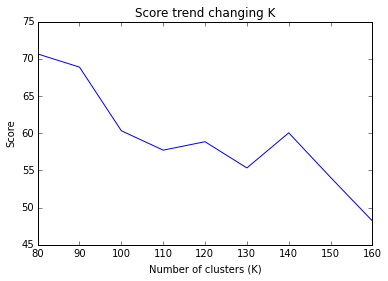

In [41]:
scores2 = np.array(scores2).reshape(-1, 1)
plt.plot(k_range2, scores2)
plt.title("Score trend changing K")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Score")

<div class="alert alert-warning">


As expected we have a better score with an higher value of k. We didn't run all the value of k due to lack of time.


</div>

## 2.4. Anomaly detection
When we have a new connection data (e.g., one that we never saw before), we simply find the closest cluster for it, and use this information as a proxy to indicate whether the data point is anomalous or not. A simple approach to decide when there is an anomaly or not, amounts to measuring the new data point’s distance to its nearest centroid. If this distance exceeds some thresholds, it is anomalous.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 12
<div class="alert alert-info">

Build your model with the best value of $k$ in your opinion. Then, detect the anomalous connections in our data. Plot and discuss your result.

</div>

<div class="label label-success">HINT</div> The threshold has strong impact on the result. Be careful when choosing it! A simple way to choose the threshold's value is picking up a distance of a data point from among known data. For example, the 100th-farthest data point distance can be an option.

In [42]:
best_k_value = 40
start_time = time.time()
clusters2 = KMeans.train(data2, best_k_value, maxIterations=10,
        runs=10, initializationMode="random")
print("Run time: ", time.time() - start_time)

/opt/spark/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


Run time:  19.877763748168945


In [43]:
cluster2LabelCount = data2.map(lambda p: (clusters2.predict(p), p)).countByKey()

In [44]:
print("Data distribution among centroids:")
for item in cluster2LabelCount:
    print(item, cluster2LabelCount[item])

Data distribution among centroids:
0 339625
1 2370054
2 12969
3 65309
4 318
5 345
6 32888
7 172891
8 2
9 217284
10 302700
11 258886
12 72387
13 43404
14 161454
15 4908
16 4
17 514215
18 116951
19 3
20 211834


In [45]:
centroids2 = clusters2.centers
distances2 = normalizedData2.map(lambda p: (euclidean_distance(centroids2[clusters2.predict(p)], p), 1))\
        .reduceByKey(lambda a,b: a+b).sortByKey(ascending=False)

print("Greater distances and their frequency:")
print(distances2.take(10))

Greater distances and their frequency:
[(2721.5015156804134, 1), (2224.8011616884601, 1), (1974.5505410119192, 1), (1584.5378153632523, 1), (1581.5780314700039, 1), (1581.3062820204509, 1), (1581.3038973041828, 1), (1581.3038777371937, 1), (1581.3036258713503, 1), (1581.2939683886279, 1)]


In [46]:
maxDistance = distances2.take(1)[0][0] #2676.9270880404379
histogram_bins = 1000
bins_width = maxDistance/histogram_bins

plot_data2 = distances2.map(lambda x: (int(x[0]/bins_width), x[1]))\
        .reduceByKey(lambda a,b: a+b).sortByKey()

    
plot_data2_vector = plot_data2.collect()
print(plot_data2_vector)

[(66, 1), (71, 155), (72, 115), (73, 74), (74, 101), (75, 274), (76, 542), (77, 918), (78, 1623), (79, 2274), (80, 4278), (81, 8063), (82, 3203629), (83, 1604138), (84, 15654), (85, 4817), (86, 45686), (87, 3197), (88, 350), (89, 86), (90, 641), (91, 97), (92, 10), (93, 362), (94, 223), (95, 45), (96, 17), (97, 55), (98, 82), (99, 4), (100, 4), (101, 2), (102, 4), (103, 4), (104, 64), (105, 114), (106, 156), (107, 18), (108, 114), (109, 3), (110, 76), (111, 26), (112, 6), (113, 16), (114, 4), (115, 1), (116, 2), (117, 5), (118, 1), (119, 2), (122, 1), (123, 2), (124, 2), (126, 1), (127, 3), (128, 6), (129, 2), (130, 4), (131, 10), (132, 4), (134, 4), (135, 5), (136, 55), (137, 5), (138, 5), (139, 5), (140, 7), (141, 20), (142, 29), (143, 5), (144, 2), (145, 4), (146, 2), (147, 1), (148, 2), (150, 1), (151, 2), (155, 1), (157, 1), (158, 1), (159, 2), (160, 1), (162, 1), (163, 1), (165, 1), (168, 1), (169, 1), (170, 1), (171, 2), (172, 1), (173, 2), (175, 28), (177, 1), (179, 1), (181, 1

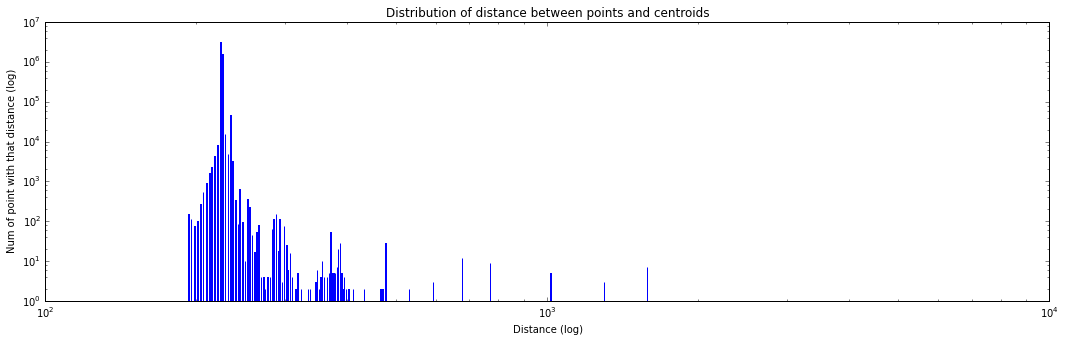

In [47]:
plt.figure(figsize=(18,5))

x = plot_data2.map(lambda x: int(x[0]*bins_width)).collect()
y = plot_data2.map(lambda x: x[1]).collect()

plt.yscale('log', nonposy='clip')
plt.xscale('log', nonposy='clip')
plt.title("Distribution of distance between points and centroids")
plt.xlabel("Distance (log)")
plt.ylabel("Num of point with that distance (log)")
barlist = plt.bar(x, y)
for i in range(0, len(barlist)):
    barlist[i].set_color('b')

plt.show()

<div class="alert alert-warning">
For the anomaly detection analisys we decided to plot a bar graph in order to understand how the distance between points and its centroid is distributed. As aspected most of the point are very close to the centroid and only some outliers are very far from it.
</div>

In [48]:
# threshold evaluation
i = len(plot_data2_vector)-1
c = 0
while(c<100 and i>=0):
    c += plot_data2_vector[i][1]
    i -=1
bin_threshold = plot_data2_vector[i][0]
print(bin_threshold)

165


In [49]:
# retrieve the farthest points and the relative features difference
THRESHOLD = bins_width*bin_threshold

farthest_points = normalizedData2.filter(lambda p: euclidean_distance(centroids2[clusters2.predict(p)], p) > THRESHOLD)
def calculate_feature_difference(point):
    nearest_centroid = clusters2.centers[clusters2.predict(point)]
    return [(i, np.abs(nearest_centroid[i] - point[i])) for i in range(len(point))]

farthest_features = farthest_points.flatMap(calculate_feature_difference)\
        .reduceByKey(lambda a,b: a+b).sortBy(lambda x: x[1], ascending=False)


<div class="alert alert-warning">
Here we are trying to understand which features influece more the distance from the centroids. This feature can be more relevant during the clustering.
</div>

In [50]:
feature_names = ['duration'] + dictionary + ['src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
        'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
        'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
        'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
        'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
        'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
        'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
        'dst_host_srv_rerror_rate']
bFeature_names = sc.broadcast(feature_names)

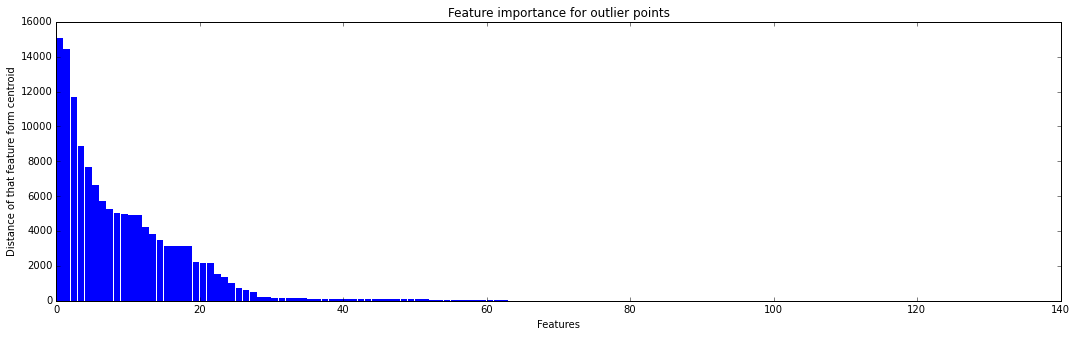

In [51]:
x = farthest_features.map(lambda x: bFeature_names.value[x[0]]).collect()
y = farthest_features.map(lambda x: x[1]).collect()

plt.figure(figsize=(18,5))
plt.title("Feature importance for outlier points")
plt.xlabel("Features")
plt.ylabel("Distance of that feature form centroid")
barlist = plt.bar(range(len(y)), y)
for i in range(0, len(barlist)):
    barlist[i].set_color('b')
plt.show()

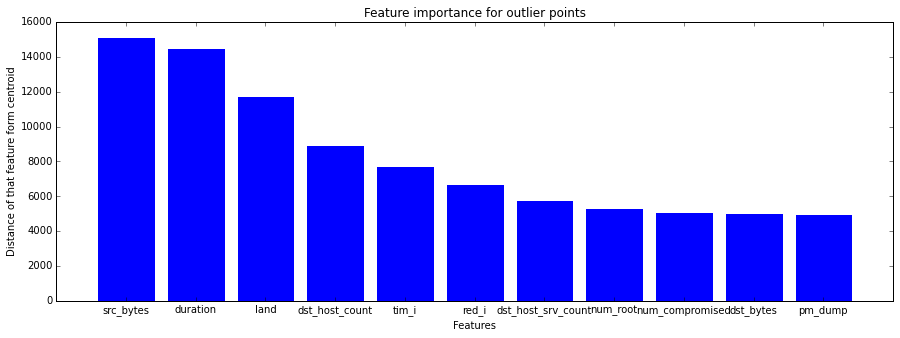

In [52]:
x2 = x[:11]
y2 = y[:11]

plt.figure(figsize=(15,5))
plt.title("Feature importance for outlier points")
plt.xlabel("Features")
plt.ylabel("Distance of that feature form centroid")
barlist = plt.bar(range(1,len(y2)+1), y2, align="center")
for i in range(0, len(barlist)):
    barlist[i].set_color('b')
plt.xticks(range(1,len(y2)+1), x2)
plt.show()


<div class="alert alert-warning">
Based on the threadshold that we used (100 farthest points) we obtained that the features that have more influence on the distance are the following
(dst_host_srv_count, land, tim_i, red_i, num_root, num_compromised, pm_dump, num_failed_logins, dst_host_count, duration, src_bytes) 
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 13
<div class="alert alert-info">

Try other methods to find the best value for $k$ such as `silhouette`, `entropy`... In particular, with this data, you can take advantage of predefined labels to calculate the quality of model using entropy... However, we suggest you to try with `silhouette`. It's more general and can work with any dataset (with and without predefined labels).

</div>

Here are some additional information about the metrics we suggest to use:
- [Silhouette](https://en.wikipedia.org/wiki/Silhouette_(clustering))
- [Hack approach to Silhouette](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- [Entropy](http://scikit-learn.org/stable/modules/clustering.html) [Lookup for entropy]

<div class="label label-danger">Note</div> you are free to play with any relevant evaluation metric you think appropriate for your work!

#### Silhouette method

This method given data point $i$ belonging to cluster $c_i$  calculate $$s(i) = (-alpha(i) + beta(i)) / (max(alpha(i), beta(i)))$$ with alpha(i) is the average similarity between $i$ and $i'$ in $c_i$, beta(i) is the min disimilarity between $i$ and other cluster != $c_i$

Our dataset contain around 4e6 data points. If we calculate the silhouette for every data point at worst we will have to store a  (4e6 x 4e6) matrix which equals 1.6e13 float number (4 bytes) which equal 6.4e13 bytes = 64000 Gigabyte. This is infeasible for the computation of this machine so we only consider a random small subset of the data for this task.

For each cluster we will take `min(cluster_size, 50)` random sample point and calculate the silhouette score of them to represent the silhouette score of the cluster.

In [53]:
cluster2Label = data2.map(lambda p: (clusters2.predict(p), p))
sample_data2 = cluster2Label.takeSample(False, 100)

In [54]:

# datapoint(ndarray), dataset(RDD)
def silhouette_score_one_point(datapoint, dataset):
    silhouette_score = dict(dataset.map(lambda x: (x[0], np.array([np.linalg.norm(x[1] - datapoint[1]), 1]) ))
                            .reduceByKey(np.add).collect())
    
    for i in silhouette_score:
        silhouette_score[i][0] = silhouette_score[i][0] / silhouette_score[i][1]
    a_i = silhouette_score[datapoint[0]][0]
    silhouette_score.pop(datapoint[0], None)
    b_i = np.amin(list(silhouette_score.values()))
    return (b_i - a_i) / np.amax([b_i, a_i])

start_time = time.time()
print(silhouette_score_one_point(sample_data2[0], cluster2Label))
print("Run time: ", time.time() - start_time)

-0.994293653653
Run time:  181.10669350624084


We tried to implement Silhouette algorithm because compared with the previous one gives a better estimation of how good data is splitted amoung different groups. But it takes a lot of time because of the distance, it's evaluated between one point and all the others and this must be done for all the points. 

For lack of time we didn't run it. We just try to run an example in 1 data point compare to 4e6 data points. The silhouette result is ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

#### Entropy method

This method calculate the entropy of each cluster and entropy of each class.

In [55]:
start_time = time.time()
clusterLabelsAndPred = labelsAndData2.map(lambda x: (clusters2.predict(x[1]), x[0])).collect()

clusterLabelsAndPred[0:5]

[(13, 'normal.'),
 (14, 'normal.'),
 (11, 'normal.'),
 (11, 'normal.'),
 (10, 'normal.')]

In [56]:

unique_label = set(x[1] for x in clusterLabelsAndPred)
translate = dict(zip(unique_label, np.arange(len(unique_label))))


In [57]:
from sklearn import metrics

homogeneity, completeness, v_measure = metrics.homogeneity_completeness_v_measure([x[0] for x in clusterLabelsAndPred], 
                                                                                  [translate[x[1]] for x in clusterLabelsAndPred])
print("Homogeneity: ", homogeneity)
print("Completeness: ", completeness)
print("V-measure: ", v_measure)
print("Run time: ", time.time() - start_time)

Homogeneity:  0.466423792075
Completeness:  0.865629202247
V-measure:  0.606207195606
Run time:  199.93537402153015


Our best model have high completeness but average homogeneity. These results show us that the clustering is still not good yet because intra-cluster class variation is still too big. 

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 14
<div class="alert alert-info">

Implement K-means on Spark so that It can work with large datasets in parallel. Test your algorithm with our dataset in this notebook. Compare our algorithm with the algorithm from MLLIB.  

<ul></ul>

Let's clarify the meaning of this question: what we want is for students to design the K-means algorithm for the parallel programming model exposed by Spark. You are strongly invited to use the Python API (pyspark). So, at the end of the day, you will operate on RDDs, and implement a `map/reduce` algorithm that performs the two phases of the standard K-means algorithm, i.e. the assignment step and the update step.

</div>

In [58]:
nCol = len(data2.first())
nRow = data2.count()
print(nCol, nRow)

122 4898431


In [59]:
# using: data2(RDD)

class ArrayAccumulatorParam(pyspark.AccumulatorParam):
    def zero(self, initialValue):
#         import numpy as np
        return initialValue

    def addInPlace(self, a, b):
        # b (pos, arr)
        a += b
        return a
            
        

In [60]:
n_cluster = 2
old_cluster_center = sc.broadcast(np.array(data2.takeSample(False, n_cluster)))
new_cluster_center = sc.accumulator(np.zeros((n_cluster, nCol)), ArrayAccumulatorParam())
cluster_point_count = sc.accumulator(np.zeros((n_cluster, 1)), ArrayAccumulatorParam())
old_cluster_center.value.shape[0]

def map_ops(x):
    global new_cluster_center
    global cluster_point_count
    cluster_idx = np.argmin(euclidean_distance_mat(old_cluster_center.value, [x]))
    tempx = np.zeros((n_cluster, nCol))
    tempx[cluster_idx, : ] = x
    new_cluster_center += tempx
    temp = np.zeros((old_cluster_center.value.shape[0], 1))
    temp[cluster_idx] = 1
    cluster_point_count += temp
    return cluster_idx

def kmean_rdd(data2, iteration=2, n_cluster=2):
    # randomize points
                  
    for i in np.arange(iteration):
        # distance calc
        print("Iteration %d " % (i))
#         print(old_cluster_center.value)
        data2.foreach(lambda x: map_ops(x))
        # clean up
#         print(new_cluster_center.value)
#         print(cluster_point_count.value)
        old_cluster_center = sc.broadcast(np.array([new_cluster_center.value[j] / cluster_point_count.value[j] 
                                                    for j in np.arange(n_cluster)]))
        for i in np.arange(n_cluster):
#             old_cluster_center.value[i] = new_cluster_center.value[i] / cluster_point_count.value[i]
            new_cluster_center.value[i] = np.zeros(new_cluster_center.value[i].shape)
            cluster_point_count.value[i] = 0
#         result = data2.map(lambda x: (np.argmin(euclidean_distance_mat([x], cluster_center)), np.array([x, 1.0])))
        # make new center
        # cluster_center = result.reduceByKey(np.add).map(lambda x: x[1][0] / x[1][1])
        # cluster_center = [x[1][0] / x[1][1] for x in result.reduceByKey(np.add).collect()]
    return old_cluster_center.value



start_time = time.time()
cluster_center = kmean_rdd(data2, iteration=2, n_cluster=2)
print("Run time: ", time.time() - start_time)


# predict kmean
# result = data2.map(lambda x: (np.argmin(euclidean_distance_mat([x], cluster_center)), x))

Iteration 0 
Iteration 1 
Run time:  92.4645586013794


Our implementation of the k-mean algorithm run much slower than the mllib version because we cannot manipulate data in lower level this implementation have collect which is the main reason for its poor performance. The speed of this algorithm depends greatly on matrix multiplication algorithm. In the distributed environment, matrix multiplication can be implement but we do not know how this could be achieve. Spark provide matrix interface and subclass to represent matrx but they require our rdd to be transform greatly so we will not attempt to use those data structure.

The reduceByKey operation has a data shuffle step inside so the computation overhead may be coming from the shuffle's I/O operation.

The accumulator contributes to the performance of the algorithm alot however, we still cannot run as fast as the library.